In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import time
import os
import re
import itertools
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import autocast
from torch.cuda.amp import GradScaler
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import MinMaxScaler


import optuna

from NF_condGLOW import *

KeyboardInterrupt: 

In [ ]:
data = pd.read_parquet('/export/home/vgiusepp/MW_MH/data/preprocessing_subsample/preprocess_training_set_Galaxy_name_subsample.parquet')
Galax_name = data['Galaxy_name'].unique()
print('Number of Galaxies:', len(Galax_name))
print('Total log10 Number of stars:', np.log10(len(data)))
print('5 Selected Galaxies:')
Galaxy_to_study = np.random.choice(Galax_name, 5)
data = data[data['Galaxy_name'].isin(Galaxy_to_study)]
for galaxy in Galaxy_to_study:
    print(galaxy, 'Log10 Number of stars:', np.log10(len(data[data['Galaxy_name'] == galaxy])))
print('Total Log10 Number of stars:', np.log10(len(data)))
data = data.sample(frac=1, )

Number of Galaxies: 4476
Total log10 Number of stars: 6.334433845531003
5 Selected Galaxies:
g2.94e10.00272 Log10 Number of stars: 2.6972293427597176
g5.59e09.00736 Log10 Number of stars: 2.6884198220027105
g1.92e10.00672 Log10 Number of stars: 2.6627578316815743
g1.08e11.00400 Log10 Number of stars: 2.696356388733332
g2.19e11.00560 Log10 Number of stars: 2.694605198933569
Total Log10 Number of stars: 3.387033701282363


In [ ]:
# data = pd.read_parquet('/export/home/vgiusepp/MW_MH/data/preprocessing/preprocess_training_set_Galaxy_name.parquet').iloc[:10_000]
# Galaxy_to_study = data['Galaxy_name'].unique()
# for galaxy in Galaxy_to_study:
#     print(galaxy, 'Log10 Number of stars:', np.log10(len(data[data['Galaxy_name'] == galaxy])))
# print('Total Log10 Number of stars:', np.log10(len(data)))

In [ ]:
cond_names = list(data.keys()[2:-1])
device = torch.device("cuda:9" if torch.cuda.is_available() else "cpu")

Flow = NF_condGLOW(n_layers=8, dim_notcond=2, dim_cond=12, CL=NSF_CL2, network_args=[128*2, 6, 0.2]).to(device=device)

losses = []
training_flow(flow = Flow, 
               data = data, 
               cond_names=cond_names, 
               epochs=100, lr=10**-4, batch_size=512, 
               loss_saver=losses, checkpoint_dir='/export/home/vgiusepp/MW_MH/tests/architecture/checkpoints/checkpoint_data/', gamma=0.998, optimizer_obj=None)
Flow.load_state_dict(torch.load('../architecture/checkpoints/checkpoint_data/checkpoint_best.pth'))
# Flow.load_state_dict(torch.load('/export/home/vgiusepp/MW_MH/tests/architecture/distributed/checkpoint.pt'))

100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


<All keys matched successfully>

In [ ]:
feh_mean, feh_std = np.load('../../data/preprocessing/mean_std_of_feh.npz')['mean'], np.load('../../data/preprocessing/mean_std_of_feh.npz')['std']
ofe_mean, ofe_std = np.load('../../data/preprocessing/mean_std_of_ofe.npz')['mean'], np.load('../../data/preprocessing/mean_std_of_ofe.npz')['std']

data['feh'], data['ofe'] = (data['feh']*feh_std + feh_mean), (data['ofe']*ofe_std + ofe_mean)

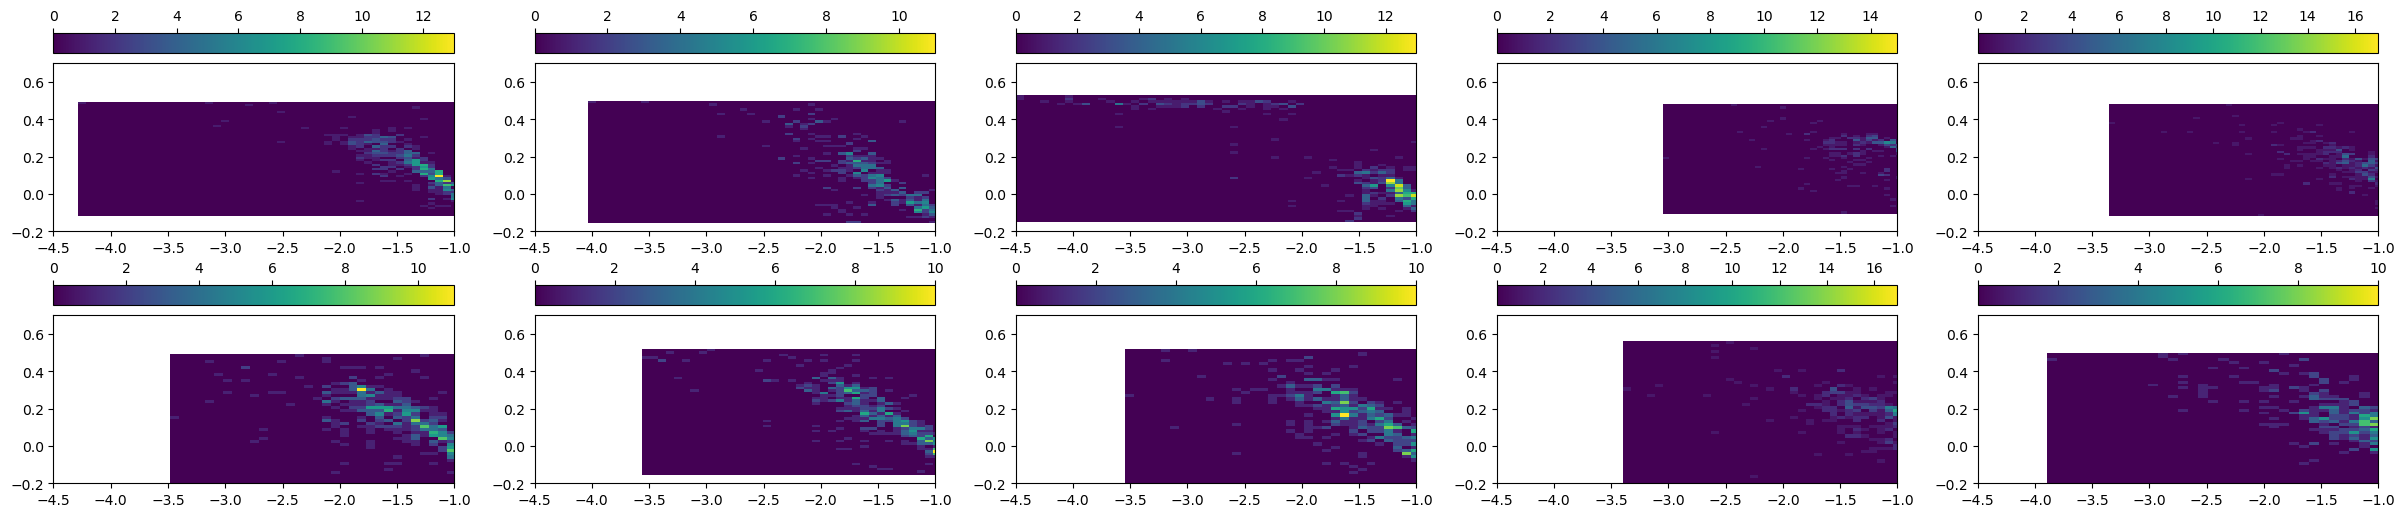

In [ ]:
fig = plt.figure(figsize=(30, 6))
bad_column = ['Galaxy_name']
other_columns = data.columns.difference(bad_column, sort=False)

i=0
for galaxy in Galaxy_to_study[:5]:
    i+=1
    ax = fig.add_subplot(2,5,i)
    cax = ax.hist2d(data[data['Galaxy_name']==galaxy]['feh'], data[data['Galaxy_name']==galaxy]['ofe'],
                    bins=50);
    fig.colorbar(cax[3], ax=ax, location='top')
    ax.set_xlim(-4.5, -1.0)
    ax.set_ylim(-0.2, 0.7)
    
    samples = Flow.sample_Flow(500, data[(data['Galaxy_name']==galaxy)][other_columns].values[0, 2:]).cpu().detach()
    ax = fig.add_subplot(2, 5, i+5)
    cax = ax.hist2d(samples[:, 0], samples[:, 1], bins=50);
    ax.set_xlim(-4.5, -1.0)
    ax.set_ylim(-0.2, 0.7)
    fig.colorbar(cax[3], ax=ax, location='top')

In [ ]:
for galaxy in Galaxy_to_study:
    
    true_data = data[data['Galaxy_name']==galaxy]
    generated_data = Flow.sample_Flow(500, data[data['Galaxy_name']==galaxy][other_columns].values[0,2:]).cpu().detach()
    generated_data = pd.DataFrame(generated_data.numpy(), columns=['feh', 'ofe'])
    
    true_data = true_data[['feh', 'ofe']]
    true_data['Data'] = 'Simulation'
    generated_data['Data'] = 'Generated'
    
    df_joinplot = pd.concat([true_data, generated_data])
    sns.jointplot(data=df_joinplot, x='feh', y='ofe', hue='Data', kind='kde')
    plt.show()
    

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 9 has a total capacity of 10.75 GiB of which 2.50 MiB is free. Process 3064680 has 6.59 GiB memory in use. Including non-PyTorch memory, this process has 4.16 GiB memory in use. Of the allocated memory 2.95 GiB is allocated by PyTorch, and 100.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)